In [1]:
from PIL import Image
import cv2 
from IPython.display import display

def imgshow(img) -> None:
    display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

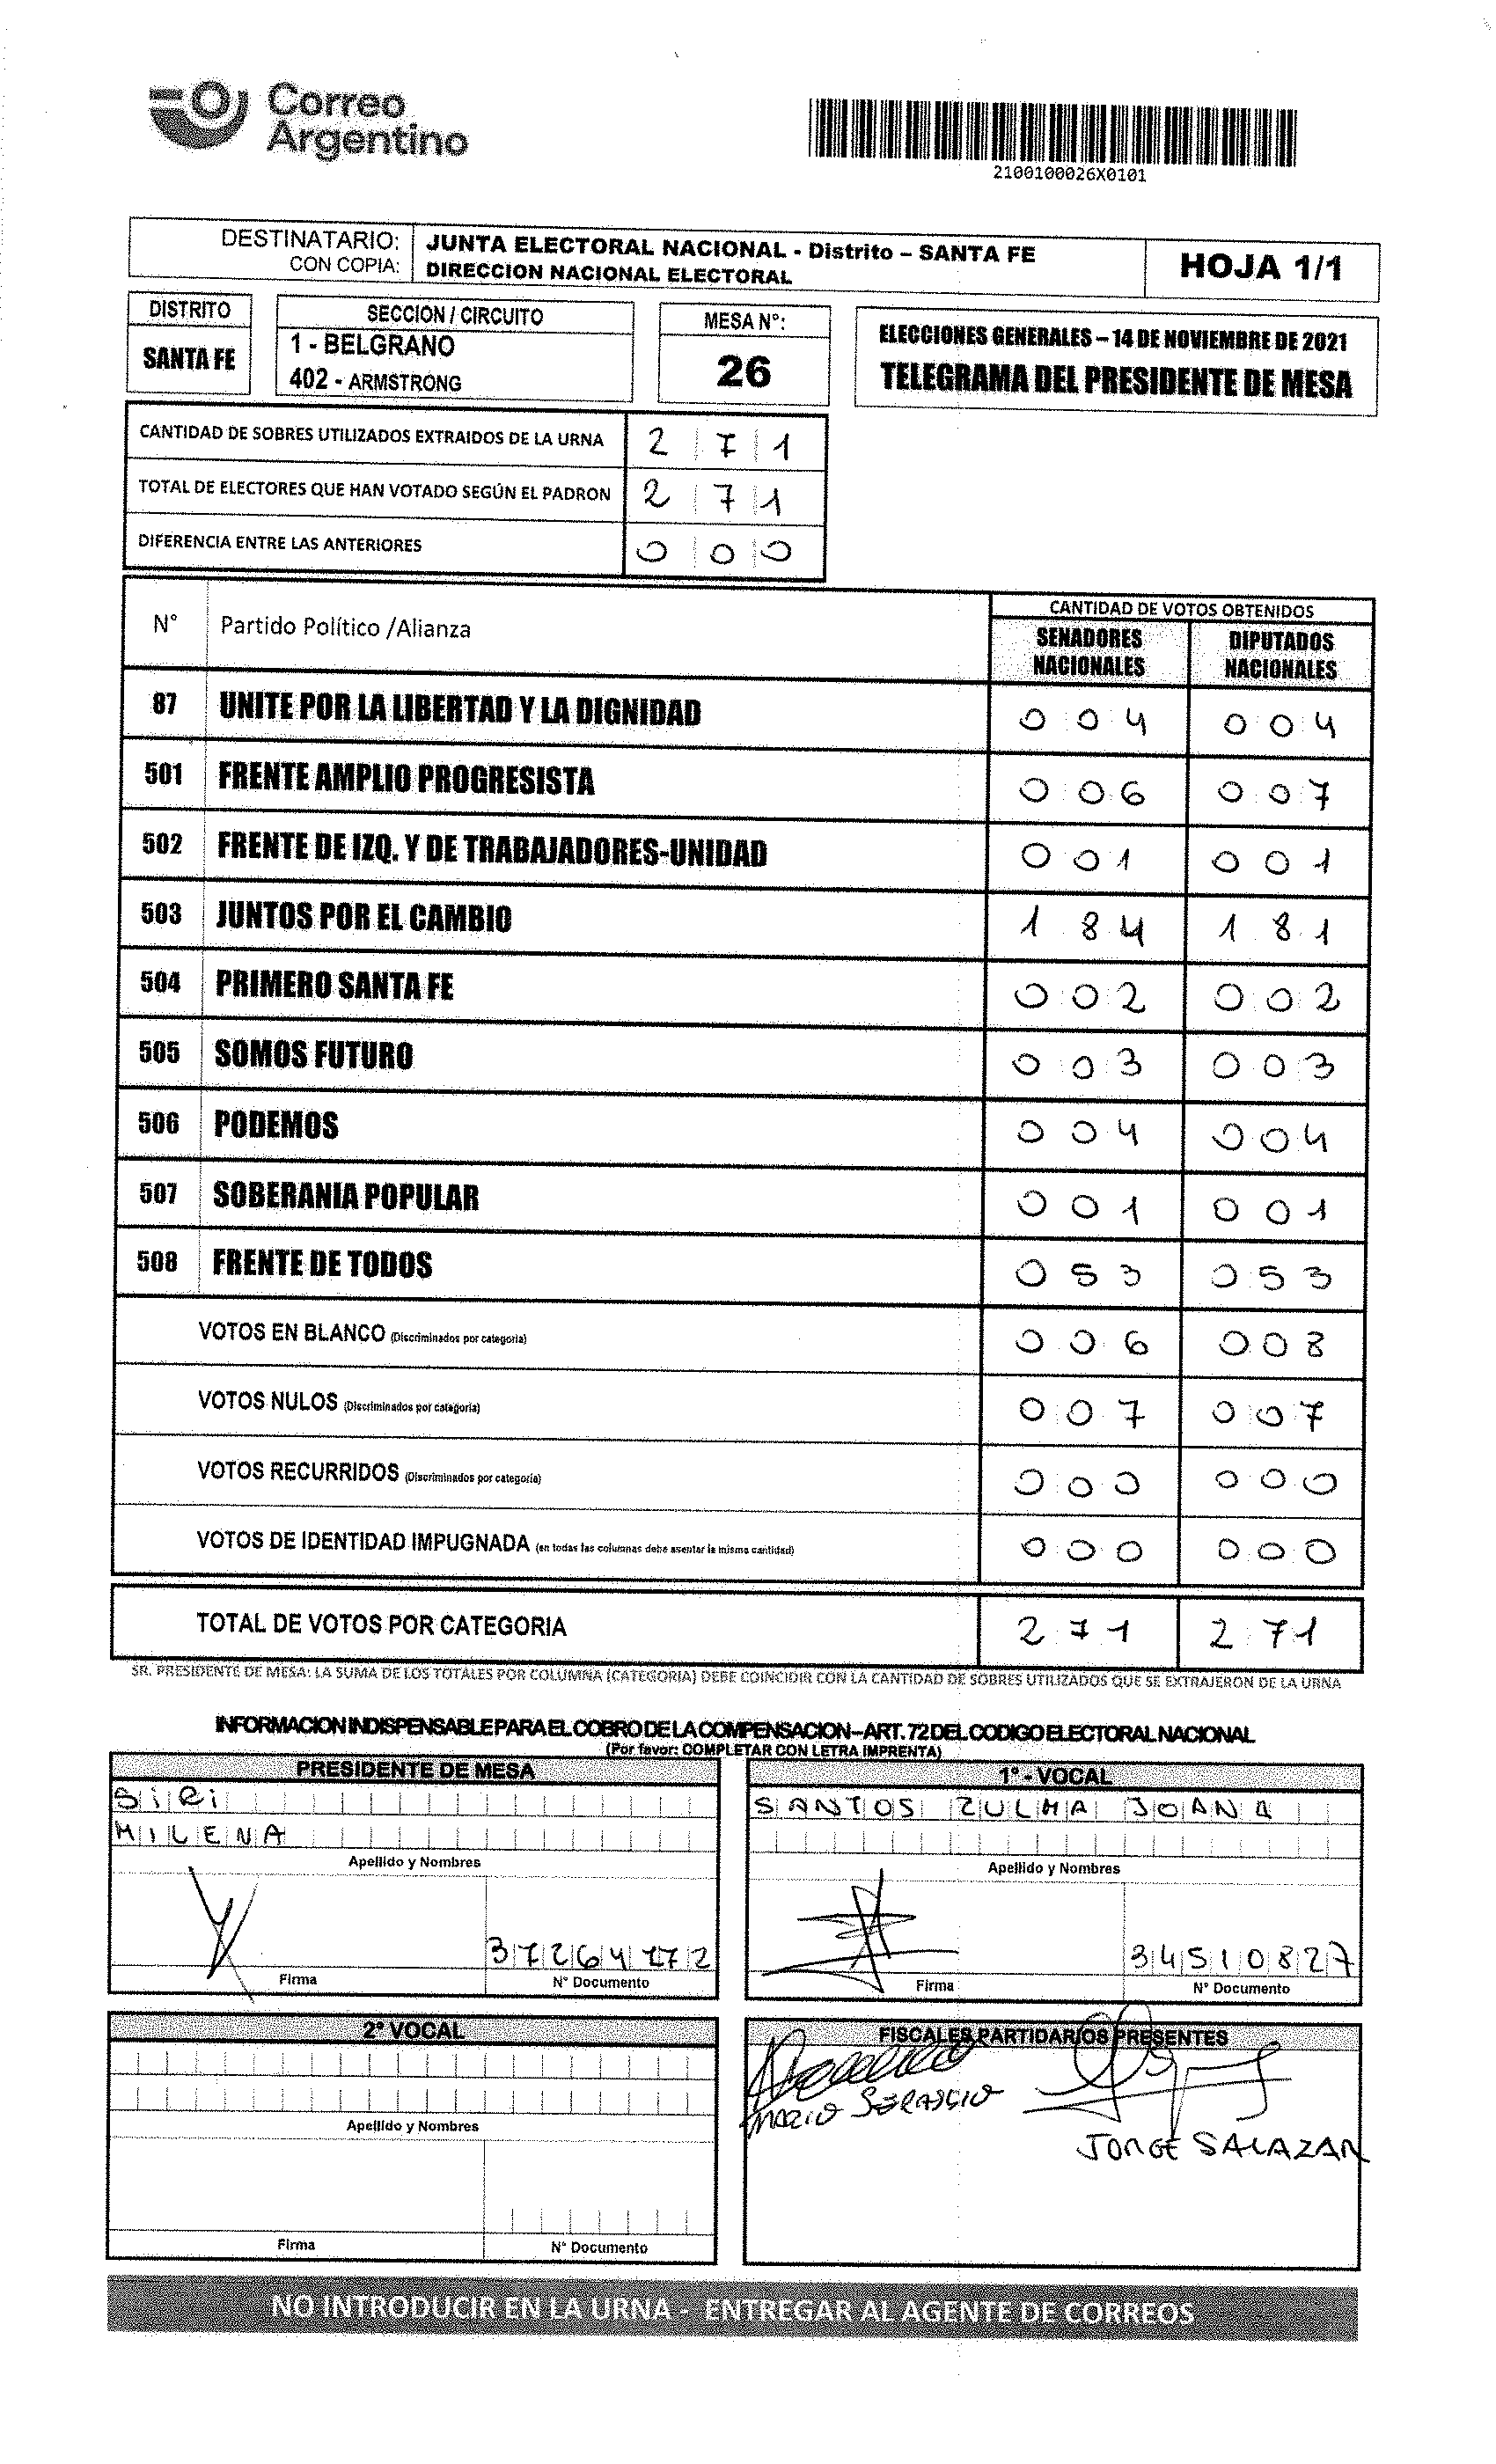

In [26]:
img_id = '2100100026X'

img = cv2.imread(f'C:/Users/Lianz/Documents/medgc-tesis/data/01_raw/telegramas/{img_id}.tiff')

imgshow(img)

Primero tenemos que enderezar la imagen

In [27]:
import numpy as np 

def get_skew_angle(image: np.ndarray) -> float:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 9)

    # Fill rectangular contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, (255, 255, 255), -1)

    # Morph open
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

    # Draw rectangles
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Buscar el rectangulo de mayor area
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    min_area_rect = cv2.minAreaRect(cnts[0])

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = min_area_rect[-1]
    if angle < -45:
        angle = 90 + angle
    if angle > 45:
        angle -= 90
    return -1.0 * angle


def rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    image_ = image.copy()
    h, w = image_.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image_ = cv2.warpAffine(image_, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return image_


def deskew(image: np.ndarray) -> np.ndarray:
    angle = get_skew_angle(image)

    # si da un valor verdura, mejor no hacemos nada
    if abs(angle) > 30:
        return image

    return rotate_image(image, -1.0 * angle)

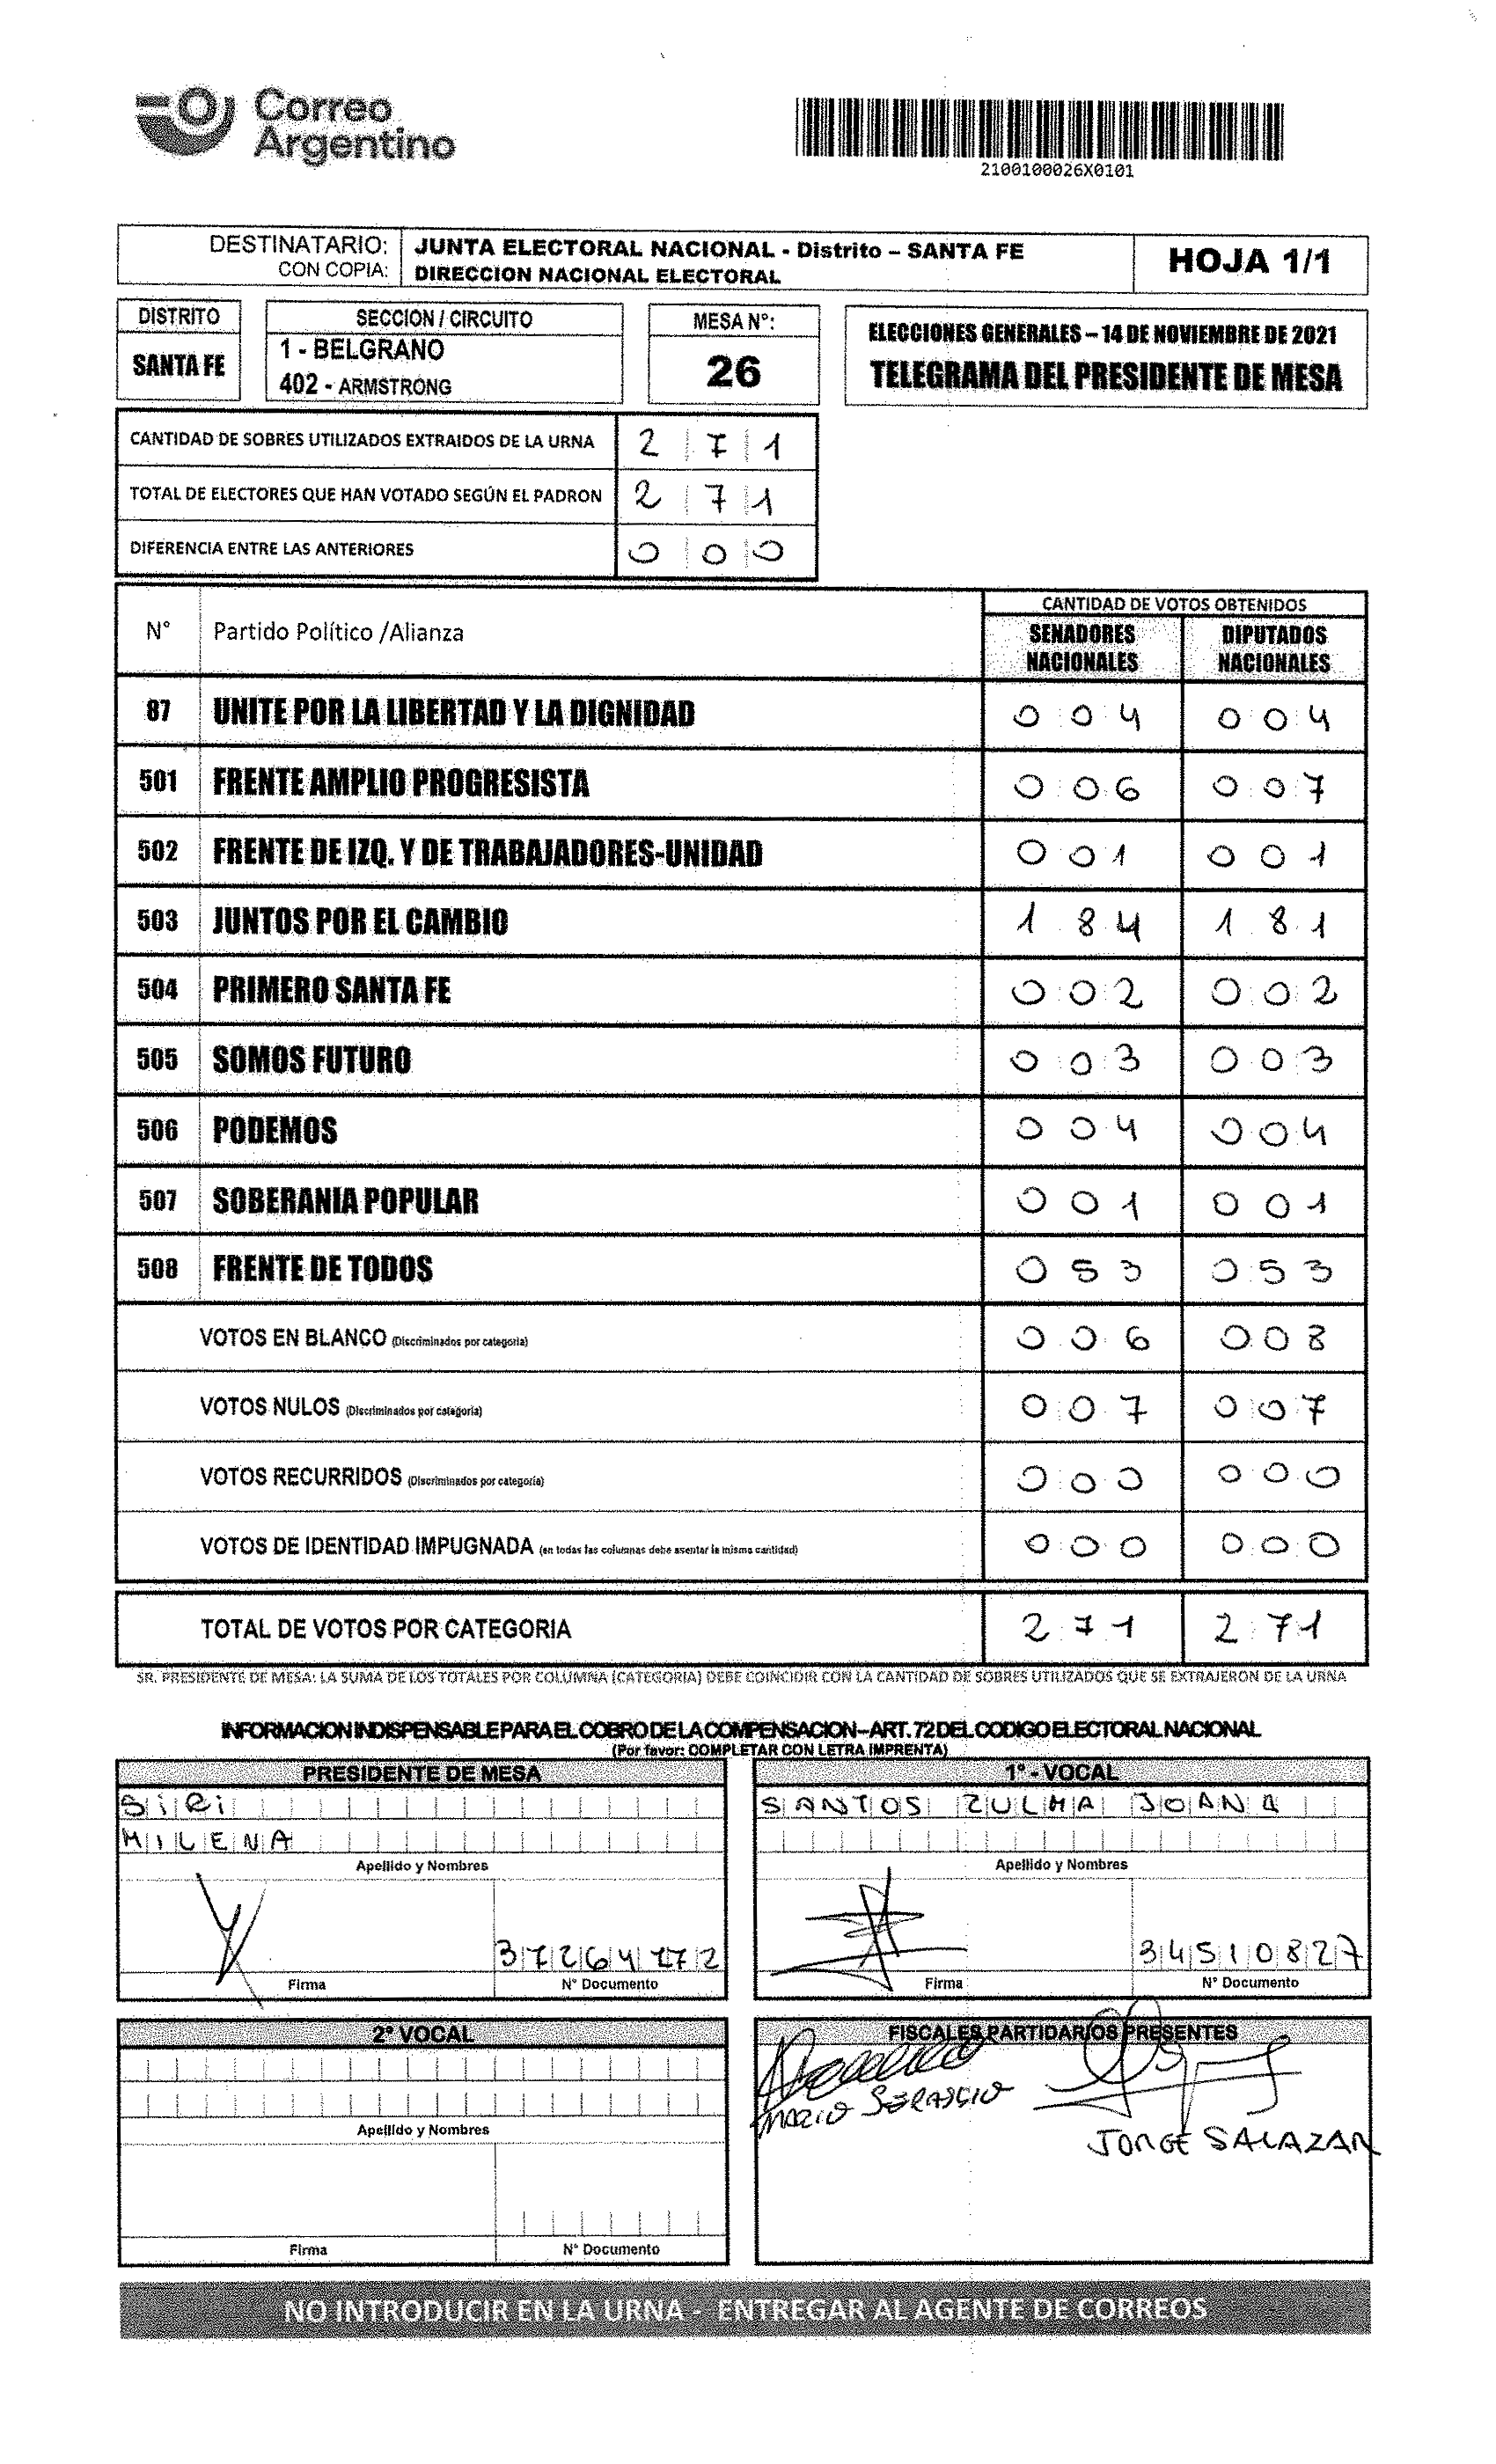

In [28]:
img = deskew(img)

imgshow(img)

Ahora vamos a reescalar

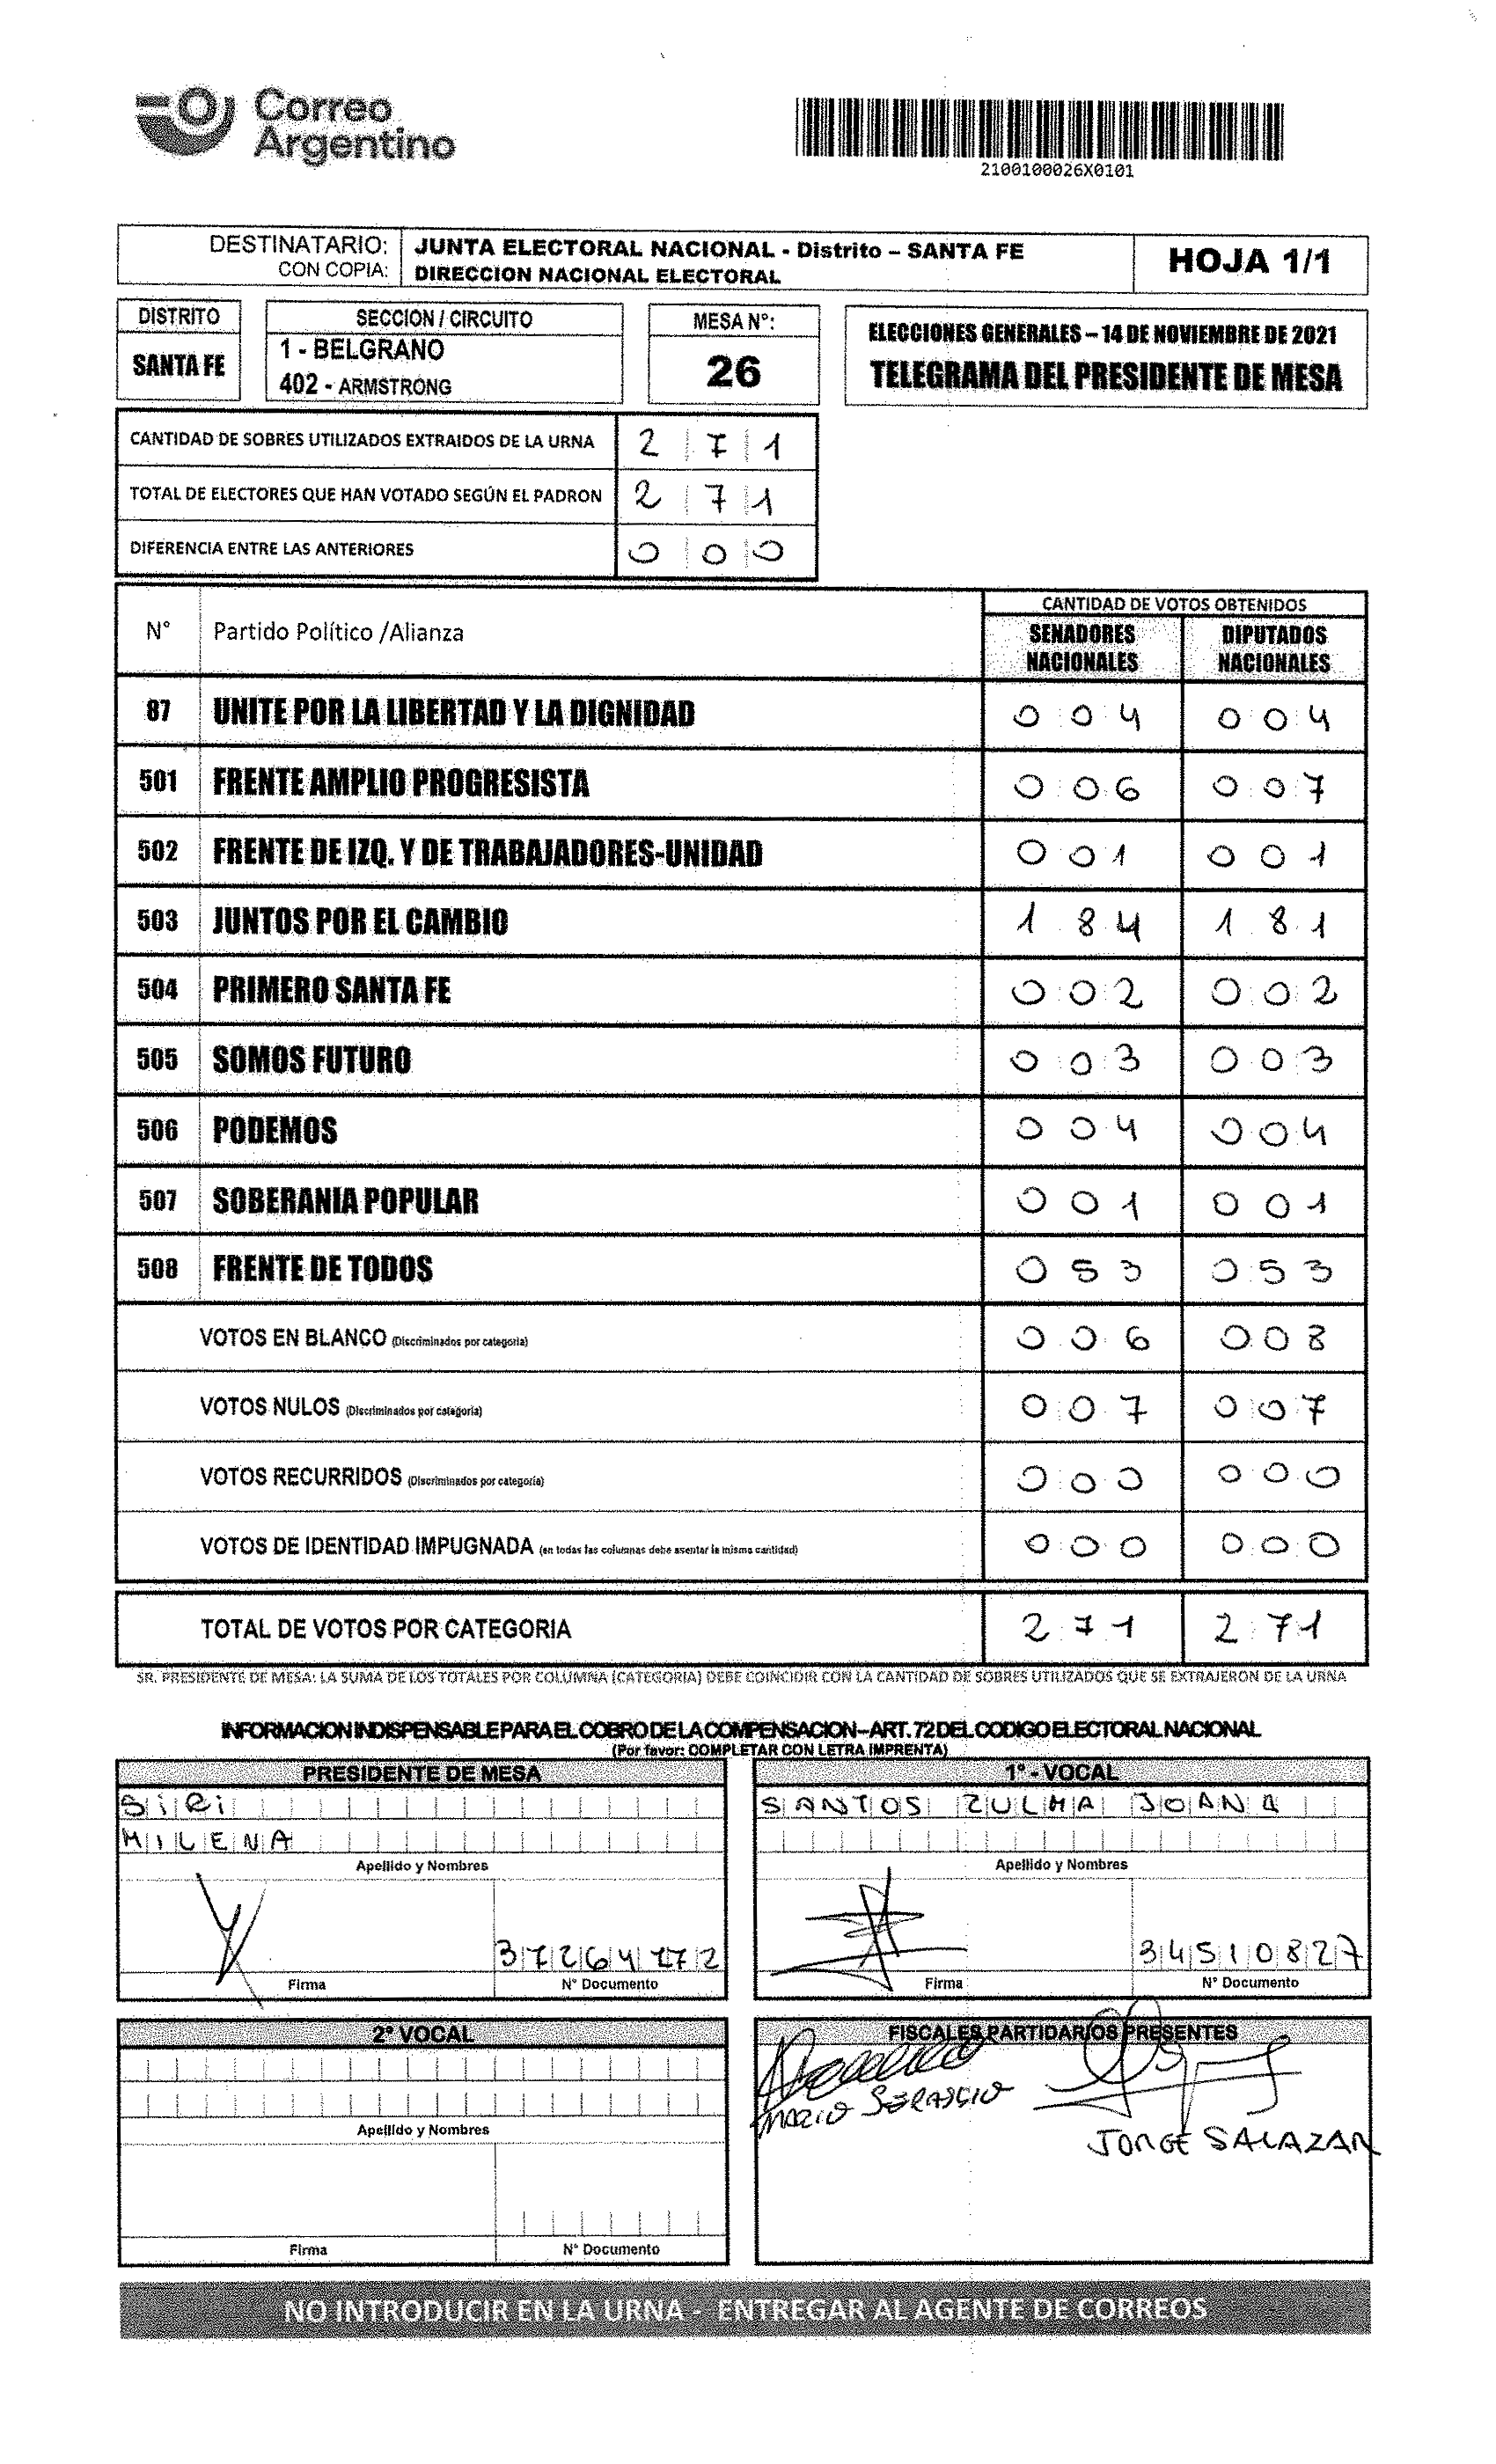

In [29]:
img = cv2.resize(img, (1700, 2800))

imgshow(img)

Ahora tenemos que quedarnos con la grilla de los votos

In [45]:
def crop_largest_rectagle(image: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 9)

    # Fill rectangular contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, (255, 255, 255), -1)

    # Morph open
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

    # Draw rectangles
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Buscar el rectangulo de mayor area
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(cnts[0])
    offset = 3
    x, y, w, h = x - offset, y - offset, w + 2 * offset, h + 2 * offset

    # Recortamos la seccion de votos
    return image[y : (y + h), x : (x + w)]

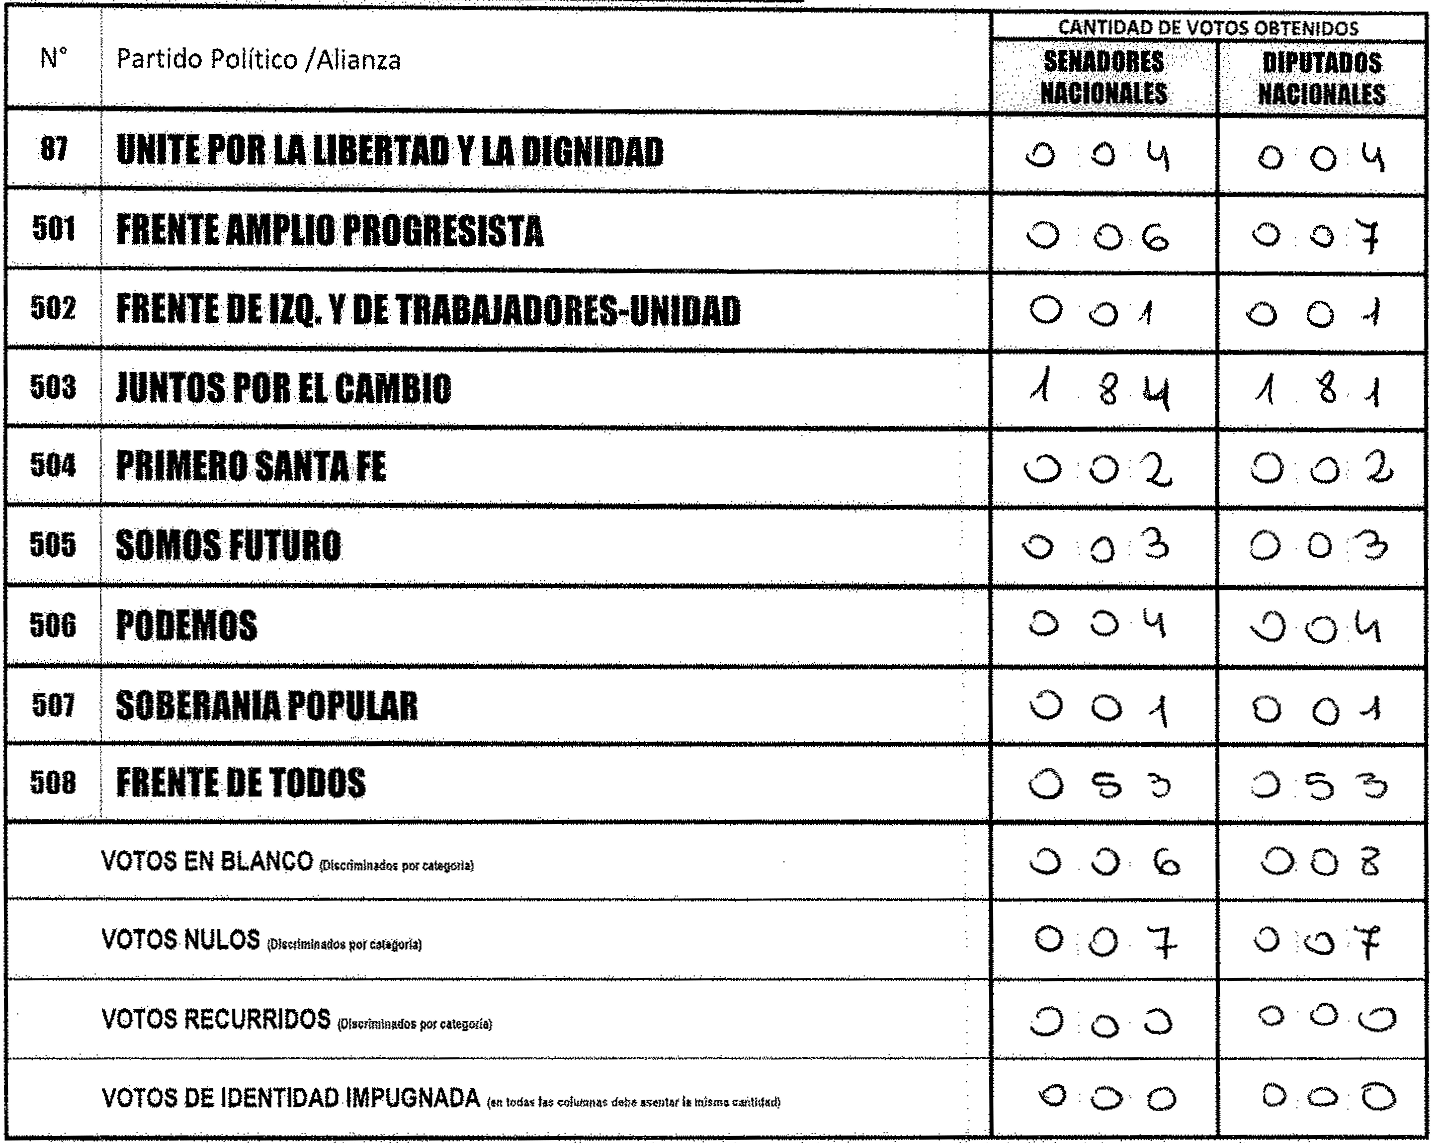

In [46]:
img_roi = crop_largest_rectagle(img)

imgshow(img_roi)

In [47]:
(img_roi.shape[0] * img_roi.shape[1]) // 70

23382

In [48]:
(img_roi.shape[0] * img_roi.shape[1]) // 30

54559

Ahora tenemos que detectar las lineas.

Podemos hacer las proyecciones de x e y, y determinar las lineas por la cantida de pixeles negros.

In [49]:
import numpy as np
from matplotlib import pyplot as plt

In [50]:
img = img_roi.copy()

proyeccion_x = np.sum(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0)
proyeccion_y = np.sum(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 1)

In [51]:
umbral_x = np.mean(proyeccion_x) - 2 * np.std(proyeccion_x)
x_negros = np.where(proyeccion_x < umbral_x)[0]

x_negros

array([   4,    5,    6,    7,  101,  988,  989,  990,  991,  992, 1215,
       1216, 1217, 1218, 1219, 1424, 1425, 1426, 1427, 1428], dtype=int64)

In [52]:
umbral_y = np.mean(proyeccion_y) - 2 * np.std(proyeccion_y)
y_negros = np.where(proyeccion_y < umbral_y)[0]

y_negros

array([   8,  109,  110,  111,  112,  113,  190,  191,  192,  269,  270,
        271,  272,  348,  349,  350,  351,  352,  426,  427,  428,  429,
        430,  504,  505,  506,  507,  508,  584,  585,  586,  587,  588,
        664,  665,  666,  667,  668,  742,  743,  744,  745,  820,  821,
        822,  823,  898,  899,  900,  978,  979, 1057, 1058, 1136, 1137,
       1138, 1139], dtype=int64)

Hay muchos pixeles parecidos, como el 0, 1, 2, 3 de x.

No tiene sentido trazar 4 lineas verticales juntas, asi que vamos a agrupar los puntos por semajanza y despues nos vamos a quedar con el medio.

Esto lo hacemos con clustering y despues nos quedamos con el punto medio del cluster.

In [53]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from typing import Iterable, Dict

In [54]:
def cluster_projection(projection: np.array, cluster_range: Iterable[int]) -> np.array:
    """
    Genera un agrupamiento optimo segun el silhouette_score de la proyeccion
    """
    best_cluster_model = None
    best_score = 0
    projection_ = projection.reshape(-1, 1)

    for n in cluster_range:
        cluster_model = AgglomerativeClustering(n_clusters=n)
        cluster_model.fit(projection_)
        score = silhouette_score(projection_, cluster_model.labels_)
        if score > best_score:
            best_score = score
            best_cluster_model = cluster_model

    return best_cluster_model.labels_

def mean_by_cluster(items: np.array, clusters: np.array) -> Dict:
    """
    Calcula el valor medio de cada cluster
    """
    means = {}

    for cluster in np.unique(clusters):
        idxs = np.where(clusters == cluster)
        cluster_items = items[idxs]
        cluster_mean = np.mean(cluster_items)
        means[cluster] = min(cluster_items, key=lambda x: abs(x - cluster_mean))

    return means

In [55]:
x_clusters = cluster_projection(x_negros, range(2, 5))
x_means = mean_by_cluster(x_negros, x_clusters)

x_means

{0: 7, 1: 1426, 2: 990, 3: 1217}

In [56]:
y_clusters = cluster_projection(y_negros, range(10, 20))
y_means = mean_by_cluster(y_negros, y_clusters)

y_means

{0: 666,
 1: 586,
 2: 428,
 3: 506,
 4: 350,
 5: 821,
 6: 270,
 7: 1137,
 8: 1057,
 9: 111,
 10: 743,
 11: 191,
 12: 899,
 13: 8,
 14: 978}

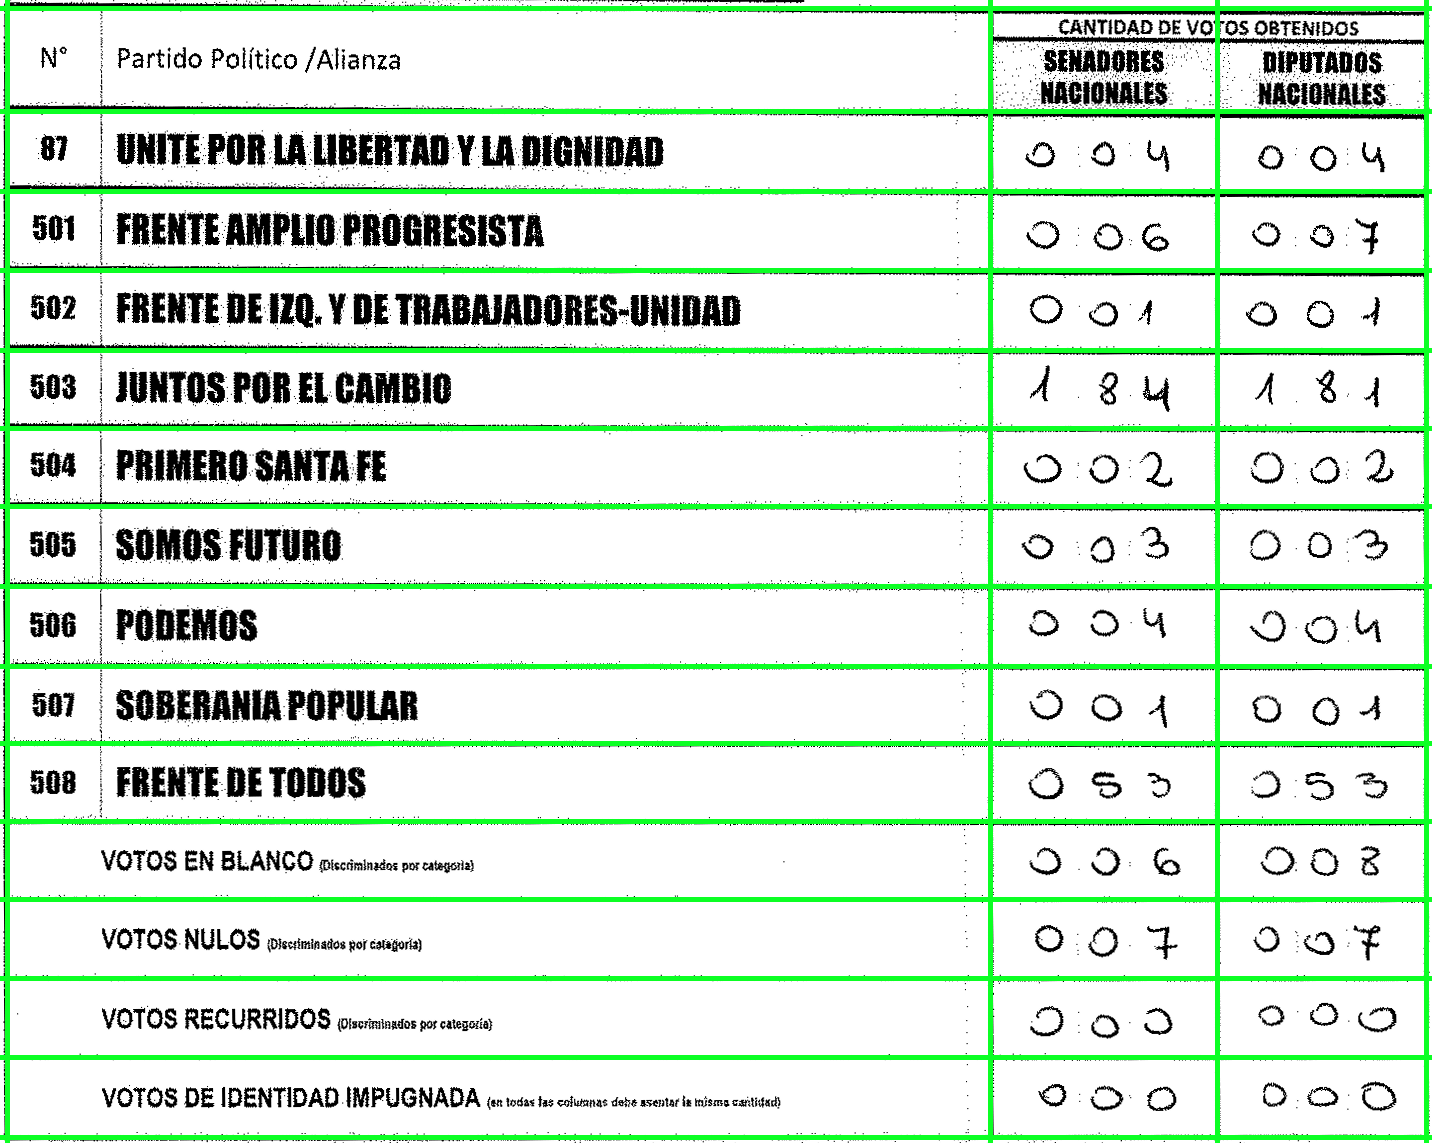

In [57]:
img_temp = img.copy()

for x in x_means.values():
    cv2.line(img_temp, (x, 0), (x, img_temp.shape[0]), (36, 255, 12), 3)

for y in y_means.values():
    cv2.line(img_temp, (0, y), (img_temp.shape[1], y), (36, 255, 12), 3)

imgshow(img_temp)

Ahora las lineas ya estan trazadas, tenemos que tomar cada rectangulo por separado. Para eso tenemos que calcular las intersecciones de las rectas.

In [58]:
from itertools import islice

def window(seq, n=2):
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [59]:
def extract_digit_blocks(xs, ys):
    for y1, y2 in window(ys, n=2):
        for idx, (x1, x2) in enumerate(window(xs, n=2)):
            # eliminamos un par de pixeles para que no se vean los recuadros negros
            offset = 5
            rect = img[y1+offset:y2-offset, x1+offset:x2-offset]
            imgshow(rect)
            
            # salteamos el primer indice de cada row, porque es el titulo del partido politico
            if idx != 0:
                yield rect

In [60]:
xs = sorted(x_means.values())
ys = sorted(y_means.values())

# Vamos a eliminar la primer row (la que tiene los titulos)
# y las ultimas 4 (votos blanco, nulos, recurridos, identidad impugnada)
ys = ys[1:11]

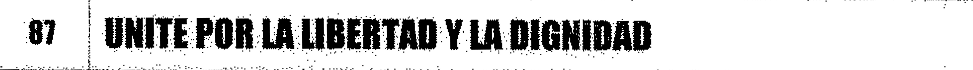

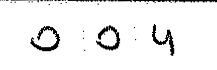

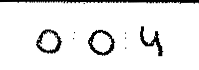

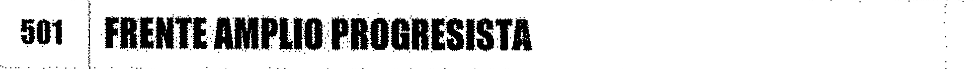

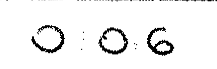

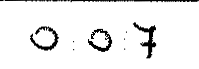

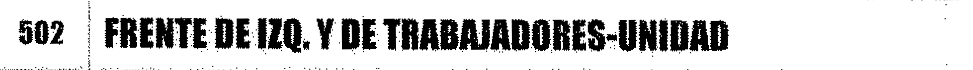

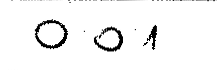

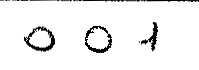

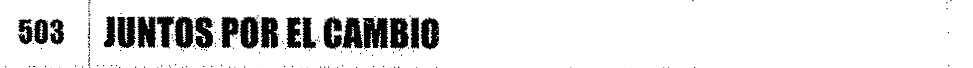

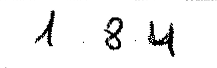

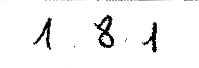

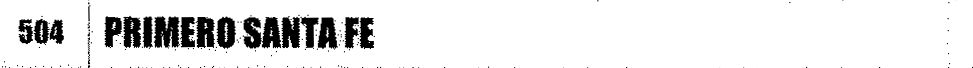

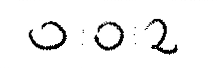

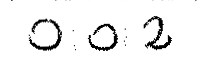

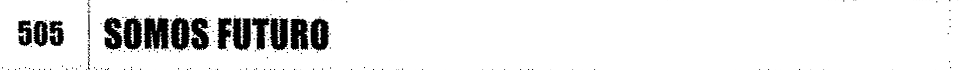

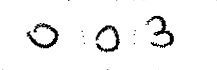

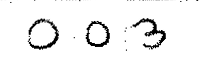

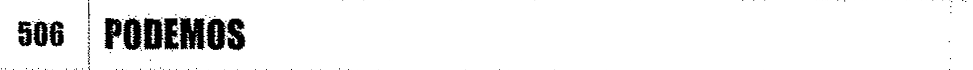

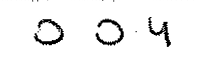

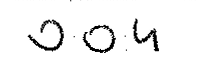

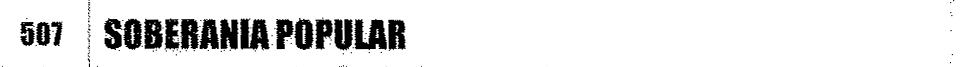

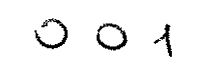

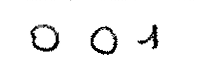

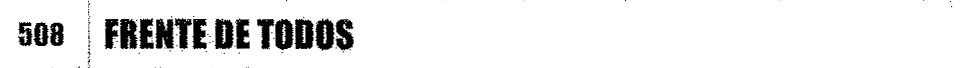

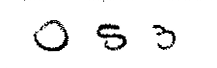

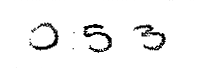

In [61]:
digit_blocks = list(extract_digit_blocks(xs, ys))

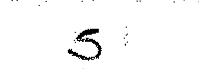

In [42]:
img_prueba = digit_blocks[1]
imgshow(img_prueba)

Ahora tendriamos que segmentar los digitos

In [62]:
def segment_digits(digit_block):
    image = digit_block.copy()

    import functools
    gray = cv2.cvtColor(digit_block, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blurring and thresholding 
    # to reveal the characters on the license plate
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)

    # Perform connected components analysis on the thresholded images and
    # initialize the mask to hold only the components we are interested in
    _, labels = cv2.connectedComponents(thresh)
    mask = np.zeros(thresh.shape, dtype="uint8")

    # Set lower bound and upper bound criteria for characters
    total_pixels = image.shape[0] * image.shape[1]
    lower = total_pixels // 70 # heuristic param, can be fine tuned if necessary
    upper = total_pixels // 5 # heuristic param, can be fine tuned if necessary
    print(total_pixels, lower, upper)

    # Loop over the unique components
    for (i, label) in enumerate(np.unique(labels)):
        # If this is the background label, ignore it
        if label == 0:
            continue

        # Otherwise, construct the label mask to display only connected component
        # for the current label
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        print(numPixels)

        # If the number of pixels in the component is between lower bound and upper bound, 
        # add it to our mask
        if numPixels > lower and numPixels < upper:
            mask = cv2.add(mask, labelMask)

    # Find contours and get bounding box for each contour
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]

    # Sort the bounding boxes from left to right, top to bottom
    # sort by Y first, and then sort by X if Ys are similar
    def compare(rect1, rect2):
        return rect1[0] - rect2[0]
    boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare))

    for x, y, w, h in boundingBoxes:
        img_digit = gray[y:(y+h), x:(x+w)]
        yield img_digit

14756 210 2951
417
462
419
1
6
1
1
1


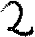

In [63]:
for digit in segment_digits(digit_blocks[-10]):
    imgshow(digit)

Ahora deberiamos hacer cuadrados cada digito, para ser similar al MNIST

In [64]:
def squarify(M, val=255):
    a, b = M.shape
    if a > b:
        pad = (a-b)//2
        offset = 0
        if (a-b) % 2 != 0:
            offset = 1
        padding=((0, 0), (pad + offset, pad))
    else:
        pad = (b-a)//2
        offset = 0
        if (b-a) % 2 != 0:
            offset = 1
        padding=((pad + offset, pad), (0, 0))
    return np.pad(M, padding, mode='constant', constant_values=val)

14756 210 2951
328
432
473
8


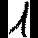

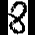

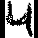

In [65]:
for digit in segment_digits(digit_blocks[6]):
    digit_square = squarify(digit, val=1)
    imgshow(digit_square)

Armamos un dataset final por row

In [66]:
dataset = []
rows = []
for digit_block in digit_blocks:
    row_digits = []
    for digit in segment_digits(digit_block):
        squared_digit = squarify(digit)
        row_digits.append(squared_digit)
    rows.append(row_digits)
        
dataset.append({
    "img_id": img_id,
    "votes": rows
})

15190 217 3038
4
22
12
28
11
67
202
395
362
326
1
3
4
1
3
13930 199 2786
448
326
374
379
1
1
1
1
1
14973 213 2994
4
2
5
1
6
9
5
17
9
7
11
7
9
13
3
425
419
414
2
2
1
3
13731 196 2746
6
344
376
377
337
1
1
2
2
15190 217 3038
2
8
2
4
2
2
1
10
2
2
2
2
2
5
6
2
8
9
6
460
211
392
1
13930 199 2786
3
4
21
23
28
214
259
393
405
14756 210 2951
328
432
473
8
13532 193 2706
2
2
1
13
13
2
410
290
250
5
7
14756 210 2951
417
462
419
1
6
1
1
1
13532 193 2706
5
3
440
480
389
2
1
2
2
1
2
1
15190 217 3038
5
1
413
405
361
5
2
4
2
3
3
13930 199 2786
7
1
5
7
1
5
440
443
356
7
1
2
3
15190 217 3038
5
5
1
5
306
406
380
2
13930 199 2786
6
454
358
431
1
14539 207 2907
447
436
270
13333 190 2666
420
406
256
14756 210 2951
2
7
489
467
307
13532 193 2706
370
425
398
2
1


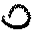

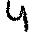

In [67]:
digitos_primer_pp = dataset[0]['votes'][0]
for digito in digitos_primer_pp:
    imgshow(digito)